### Code to generate Figure 3 - Haplogroup networks

In [1]:
%run setup.ipynb
%matplotlib inline
import hapclust
import matplotlib.patches as patches

#### setup data

In [3]:
callset = h5py.File('../data/ag1000g.phase1.AR3.1.haplotypes.specific_regions.2L_2358158_2431617.h5', mode='r')
region_vgsc = SeqFeature('2L', 2358158, 2431617)
genotypes = allel.GenotypeArray(callset['2L/calldata/genotype'])
haplotypes = genotypes.to_haplotypes()
pos = allel.SortedIndex(callset['2L/variants/POS'])
loc = pos.locate_range(region_vgsc.start, region_vgsc.end)
h_vgsc = haplotypes[loc]
pos_995S = 2422651
pos_995F = 2422652
loc_995S = haplotypes[pos.locate_key(pos_995S)] == 1
loc_995F = haplotypes[pos.locate_key(pos_995F)] == 1
h_vgsc_995F = h_vgsc.compress(loc_995F, axis=1)
h_vgsc_995S = h_vgsc.compress(loc_995S, axis=1)
sample_ids = callset['2L']['samples'][:]
hap_ids = np.array(list(itertools.chain(*[[s + b'a', s + b'b'] for s in sample_ids])))
hap_ids_995F = hap_ids[loc_995F]
hap_ids_995S = hap_ids[loc_995S]
tbl_haplotypes = etl.fromtsv('../data/ag1000g.phase1.AR3.1.haplotypes.meta.txt')
hap_pops = np.array(tbl_haplotypes.values('population'))
hap_pops_995S = hap_pops[loc_995S]
hap_pops_995F = hap_pops[loc_995F]

# need to use named colors for graphviz
pop_colors = {
    'AOM': 'brown',
    'BFM': 'firebrick1',
    'GWA': 'goldenrod1',
    'GNS': 'cadetblue1',
    'BFS': 'deepskyblue',
    'CMS': 'dodgerblue3',
    'UGS': 'palegreen',
    'GAS': 'olivedrab',
    'KES': 'grey47',
    'colony': 'black'
}
hap_colors = np.array([pop_colors[p] for p in hap_pops])
hap_colors_995S = np.array([pop_colors[p] for p in hap_pops_995S])
hap_colors_995F = np.array([pop_colors[p] for p in hap_pops_995F])

#### generate clusters

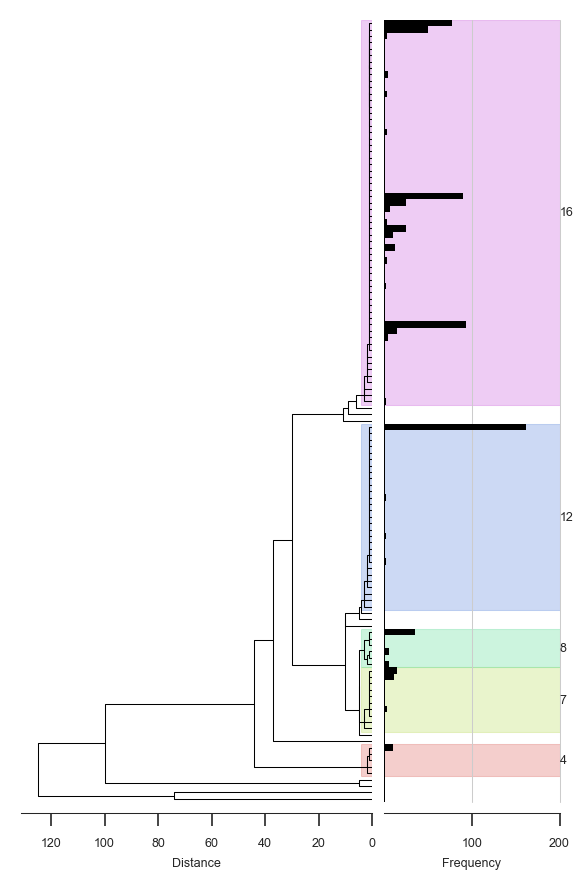

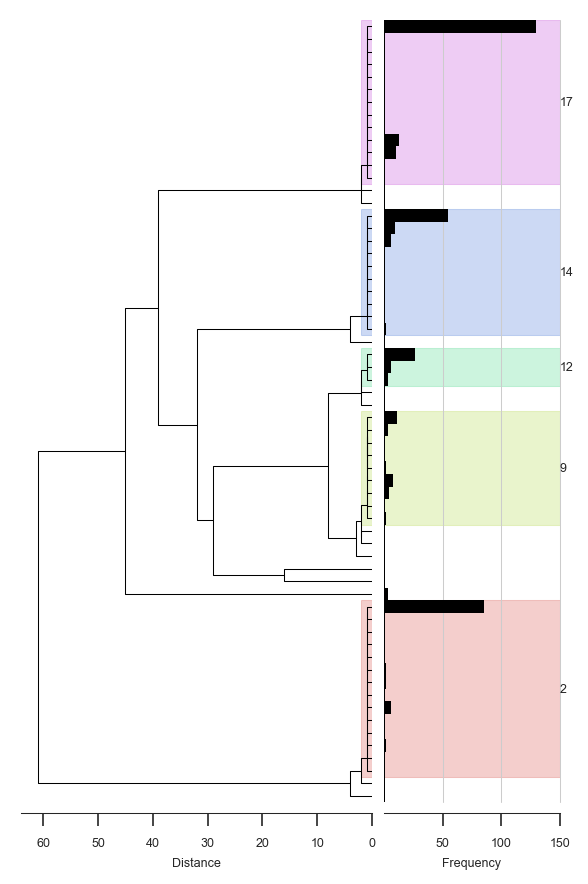

In [6]:
#dendrogram cut height 4
_, _, _, cluster_spans_995F, _ = hapclust.fig_haplotypes_clustered(h_vgsc_995F, orientation='left', cut_height=4, dpi=150, 
                                                                   highlight_clusters=5, label_clusters=5)
#dendrogram cut height 2
_, _, _, cluster_spans_995S, _ = hapclust.fig_haplotypes_clustered(h_vgsc_995S, dpi=150, highlight_clusters=5, label_clusters=5,
                                                                   orientation='left')

#### add labels

In [9]:
tbl_variant_labels = (
    etl
    .frompickle('../data/tbl_variants_phase1.pkl')
    .eq('num_alleles', 2)
    .cut('POS', 'AGAP004707-RA')
    .convert('AGAP004707-RA', lambda v: v[1] if v[0] == 'NON_SYNONYMOUS_CODING' else '')
    .rename('AGAP004707-RA', 'label')
)
tbl_variant_labels

0|POS,1|label
2358254,D33N
2358316,
2358328,
2358353,
2358405,


In [10]:
pos2label = tbl_variant_labels.lookupone('POS', 'label')
pos2label[pos_995F]

'L995F'

In [11]:
variant_labels = np.array([pos2label.get(p, '') for p in pos], dtype=object)
variant_labels_vgsc = variant_labels[loc]
variant_labels_vgsc[:5]

array(['D33N', '', '', '', ''], dtype=object)

#### produce mjn networks for each of the haplogroup clusters in svg format to build Figure 3 in Inkscape
- 995F

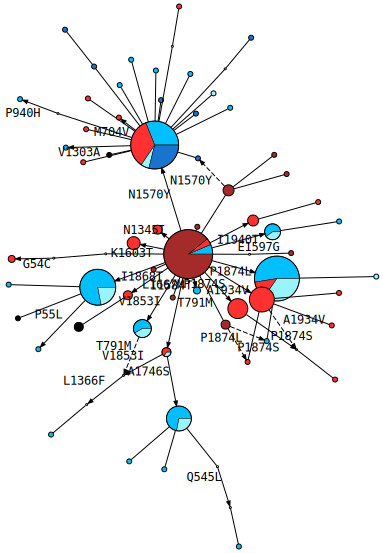

In [13]:
#check what the cluster nets looks like in mjn
#generate a 'graph'
cluster_idx = 16
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph16 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)
graph16

graph16.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995F_cluster_16_mjn'
graph16.render(fn)

graph16

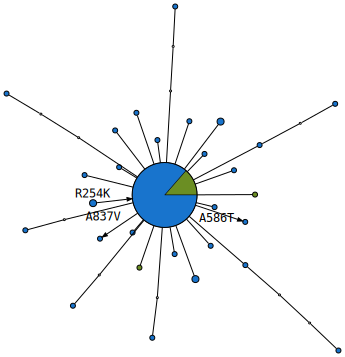

In [15]:
cluster_idx = 12
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph12 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)


graph12.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995F_cluster_12_mjn'
graph12.render(fn)

graph12

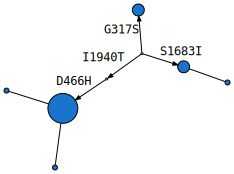

In [16]:
cluster_idx = 8
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph8 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                          network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                          show_node_labels=10000, fontsize='12', 
                                          variant_labels=variant_labels_vgsc, max_dist=4)

graph8.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995F_cluster_8_mjn'
graph8.render(fn)

graph8

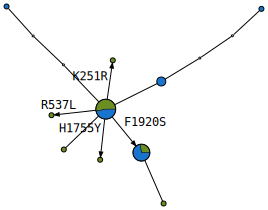

In [17]:
cluster_idx = 7
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph7 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                          network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                          show_node_labels=10000, fontsize='12', 
                                          variant_labels=variant_labels_vgsc, max_dist=4)

graph7.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995F_cluster_7_mjn'
graph7.render(fn)

graph7

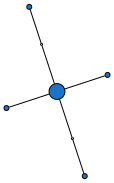

In [19]:
cluster_idx = 4
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995F[cluster_idx]
cluster_haps = h_vgsc_995F.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995F[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph4 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                 network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                 show_node_labels=10000, fontsize='12', 
                                 variant_labels=variant_labels_vgsc, max_dist=4)

graph4.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995F_cluster_4_mjn'
graph4.render(fn)

graph4

- 995S

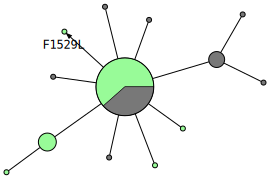

In [21]:
cluster_idx = 17
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995S[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995S[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph17 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)
graph17

graph17.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995S_cluster_17_mjn'
graph17.render(fn)

graph17

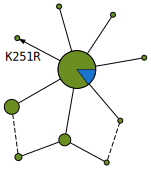

In [23]:
cluster_idx = 14
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995S[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995S[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph14 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)
graph14

graph14.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995S_cluster_14_mjn'
graph14.render(fn)

graph14

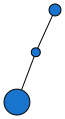

In [24]:
cluster_idx = 12
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995S[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995S[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph12 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)
graph12

graph12.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995S_cluster_12_mjn'
graph12.render(fn)

graph12

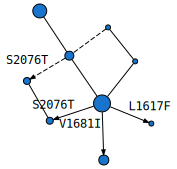

In [25]:
cluster_idx = 9
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995S[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995S[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph9 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)
graph9

graph9.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995S_cluster_12_mjn'
graph9.render(fn)

graph9

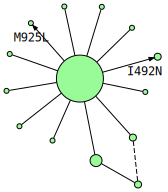

In [26]:
cluster_idx = 2
dend_start, dend_stop, cluster_hap_indices = cluster_spans_995S[cluster_idx]
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_hap_pops = hap_pops_995S[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph2 = hapclust.graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors, mode='KK', 
                                           network_method='mjn',edge_weight=12, overlap=True, splines=False,
                                           show_node_labels=10000, fontsize='12', 
                                           variant_labels=variant_labels_vgsc, max_dist=4)
graph2

graph2.format = 'svg'
fn = '/home/chris/Git/agam-vgsc-report/artwork/995S_cluster_2_mjn'
graph2.render(fn)

graph2